In [21]:
import pandas as pd 
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

In [30]:
rating_df = pd.read_csv("ml-latest-small/ratings.csv", usecols=['userId', 'movieId', 'rating'])
rating_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


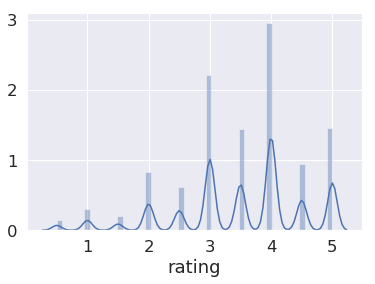

In [9]:
sns.distplot(rating_df['rating'])

In [10]:
movies_df = pd.read_csv("ml-latest-small/movies.csv", usecols=['movieId', 'title', 'genres'])
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
df = pd.merge(movies_df, rating_df, on="movieId")
df.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


In [12]:
# Split and create different genre
genre_labels = set()
for i in movies_df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(i))
    
genre_labels

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

### Function that counts the number of times each of the genre keywords appear

In [13]:
def count_word(dataset, column, census):
    keyword_count = dict()
    for s in census:
        keyword_count[s] = 0
        
    for census_keywords in dataset[column].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue
            
        for i in [i for i in census_keywords if i in census]:
            if pd.notnull(i): 
                keyword_count[i] += 1

    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies_df, 'genres', genre_labels)
keyword_occurences

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596],
 ['Adventure', 1263],
 ['Crime', 1199],
 ['Sci-Fi', 980],
 ['Horror', 978],
 ['Fantasy', 779],
 ['Children', 664],
 ['Animation', 611],
 ['Mystery', 573],
 ['Documentary', 440],
 ['War', 382],
 ['Musical', 334],
 ['Western', 167],
 ['IMAX', 158],
 ['Film-Noir', 87],
 ['(no genres listed)', 34]]

### Split the genre for the training

In [14]:
movies_df['genres'] = movies_df['genres'].str.split('|')

# Convert genres to string value
movies_df['genres'] = movies_df['genres'].fillna("").astype('str')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
1,2,Jumanji (1995),"['Adventure', 'Children', 'Fantasy']"
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']"
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']"
4,5,Father of the Bride Part II (1995),['Comedy']


### Using Tf idf Vectorizer

In [24]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_df['genres'])
tfidf_matrix.shape

(9742, 177)

### Using linear_kernel

In [17]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.31379419, 0.0611029 , 0.05271111],
       [0.31379419, 1.        , 0.        , 0.        ],
       [0.0611029 , 0.        , 1.        , 0.35172407],
       [0.05271111, 0.        , 0.35172407, 1.        ]])

### Using cosine_similarity

In [19]:
cosine_sima = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sima[:4, :4]

array([[1.        , 0.31379419, 0.0611029 , 0.05271111],
       [0.31379419, 1.        , 0.        , 0.        ],
       [0.0611029 , 0.        , 1.        , 0.35172407],
       [0.05271111, 0.        , 0.35172407, 1.        ]])

In [28]:
# Build a 1-dimensional array with movie titles
titles = movies_df['title']
indices = pd.Series(movies_df.index, index=movies_df['title'])

# getting movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [29]:
genre_recommendations('Grumpier Old Men (1995)')

6                          Sabrina (1995)
35                        Clueless (1995)
57                   Two if by Sea (1996)
60     French Twist (Gazon maudit) (1995)
103                   If Lucy Fell (1996)
106                      Boomerang (1992)
111                 Pie in the Sky (1996)
152                       Mallrats (1995)
157                    Nine Months (1995)
203                   Forget Paris (1995)
216                           I.Q. (1994)
238                     Milk Money (1994)
248             Nina Takes a Lover (1994)
250                       Only You (1994)
255              Perez Family, The (1995)
256     Pyromaniac's Love Story, A (1995)
297        While You Were Sleeping (1995)
315    Four Weddings and a Funeral (1994)
335                     Speechless (1994)
361                      Barcelona (1994)
Name: title, dtype: object